In [71]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [80]:
# define functions
def LinearFunc(t, a, b):
    return a * t + b

def AiryFunc(t, B, A, F, T, t0):
    return B + A / ( 1 + F * (np.sin( (np.pi/T)*(t-t0) ))**2 )

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope, FPDriveSlope, FP_Period):
    return ( (DriveSlope * 10) / (FPDriveSlope*FP_Period) )*(t - t0)

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -((x - ctr)/wid)**2)
    return y

## Calibration with the Fabry-Perot

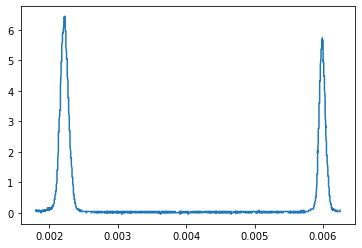

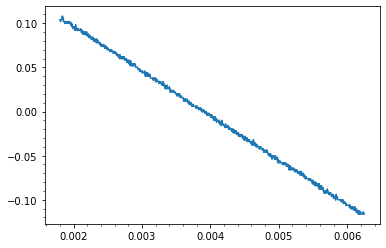

In [81]:
# Importing and formatting data

# Reading Files
ramp0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH1.CSV")
FP0 = pd.read_csv("New Data/Calibration (Widest)/A0032CH2.CSV")

#Seperating Data
RawRampTime = pd.DataFrame(ramp0, columns= ['col 1'])
RawRamp = pd.DataFrame(ramp0, columns= ['col 2'])
RawFPTime = pd.DataFrame(FP0, columns= ['col 1'])
RawFP = pd.DataFrame(FP0, columns= ['col 2'])

#Formatting Data
RampTime = np.resize(RawRampTime,(4000,1))
Ramp = np.resize(RawRamp,(4000,1))
FabryTime = np.resize(RawFPTime,(4000,1))
Fabry = np.resize(RawFP,(4000,1))

t_start = 0.0018
t_end = 0.00625

#pulling out important indices
j = 0
for i in FabryTime: 
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    if i == 0.0027:
        tf1 = j
    if i == 0.0055:
        tf2 = j
    j += 1

#Resizing and cutting
BackgroundT_pts = FabryTime[tf1:tf2,0]
BackgroundFabry = Fabry[tf1:tf2,0]

RampTime = RampTime[t1:t2,0]
Ramp = Ramp[t1:t2,0]
FabryTime = FabryTime[t1:t2,0]
Fabry = Fabry[t1:t2,0]

#DoubleChecking Times
TimeDiff = RampTime - FabryTime

for i in TimeDiff:
    if i != 0:
        print("ERROR")
        
t_pts = FabryTime

plt.plot(t_pts, Fabry)
plt.show()
plt.plot(t_pts, Ramp*(1))
#plt.plot(BackgroundT_pts, BackgroundFabry)
plt.minorticks_on()

In [82]:
# Finding the error for our fit
BackgroundGuess = [0, 0.02]

BackParam, BackParam_cov = curve_fit(LinearFunc, BackgroundT_pts, BackgroundFabry, BackgroundGuess, maxfev=150000)

FPV_error = np.sqrt( sum( (BackgroundFabry - LinearFunc(BackgroundT_pts, *BackParam))**2 ) / (np.size(BackgroundT_pts) - 2) )
FPV_errorArray = FPV_error * np.linspace(1,1,np.size(t_pts))
print("")
print("Error in the voltage for the Fabry-Perot = (+/-) " + str(FPV_error) + " V")


Error in the voltage for the Fabry-Perot = (+/-) 0.020478307755054048 V



index 0 = -0.057733425024948964 +/- 0.006112601857593265
index 1 = 6.397591186499927 +/- 0.039800003795294255
index 2 = 550.9051571754346 +/- 10.35723055993203
index 3 = 0.0037712480828737092 +/- 6.360550554642151e-07
index 4 = 0.0022162486963091224 +/- 4.497310172885512e-07

Chi Squared = 336189.1609859879
Reduced Chi Squared = 151.5731113552696


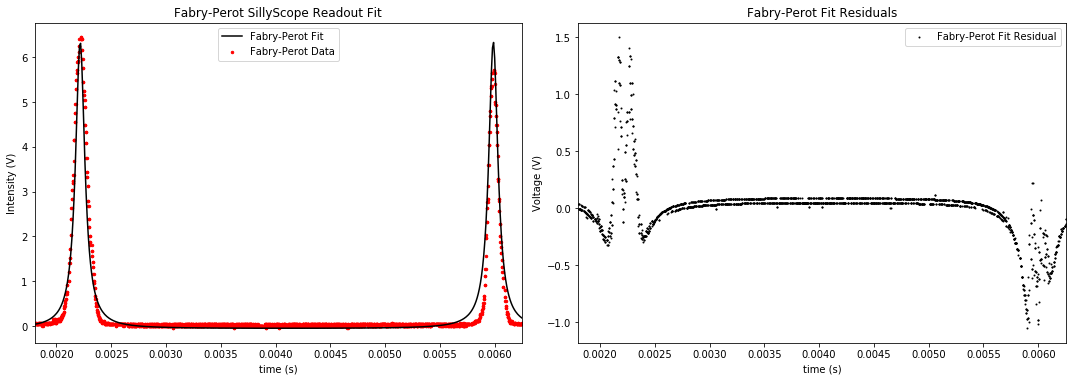

In [83]:
# Fitting and plotting the Fabry-Perot

FPGuess = [0, 6, 550, .00377, .0022]
FPParam, FPParam_cov = curve_fit(AiryFunc, t_pts, Fabry, FPGuess, sigma= FPV_errorArray, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

i = 0
while i < 5:
    print("index " + str(i) + " = " + str(FPParam[i]) + " +/- " + str(np.sqrt(FPParam_cov[i,i])) )
    i += 1
    
FP_Period = FPParam[3]
FP_Period_Err = np.sqrt(FPParam_cov[3,3])

print("")
FP_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
FP_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

print("Chi Squared = " + str(FP_CS))
print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure(figsize=(15,10))
FPplt = fig.add_subplot(2,2,1)
#FPplt.scatter(RelativeFreq, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.scatter(t_pts, Fabry, label='Fabry-Perot Data', color='red', s=6)
FPplt.plot(t_pts, AiryFunc(t_pts, *FPParam), label='Fabry-Perot Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

FPResidplt = fig.add_subplot(2,2,2)
FPResidplt.scatter(t_pts, (Fabry - AiryFunc(t_pts, *FPParam)), label='Fabry-Perot Fit Residual', color='black', s=1)
FPResidplt.set_xlim(t_start,t_end)
FPResidplt.set_xlabel("time (s)")
FPResidplt.set_ylabel('Voltage (V)')
FPResidplt.set_title('Fabry-Perot Fit Residuals')
FPResidplt.legend();

fig.tight_layout()


index 0 = -50.467716776196674 +/- 0.021186683505510274
index 1 = 0.19723452497227323 +/- 8.957483239461056e-05



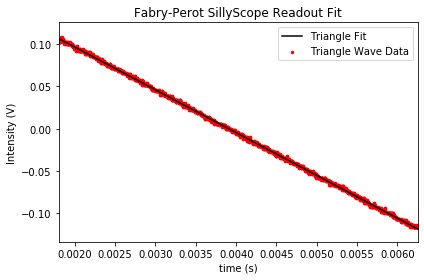

In [84]:
# Fitting and plotting the Triangle Wave

TriGuess = [-0.06, 6.4]
TriParam, TriParam_cov = curve_fit(LinearFunc, t_pts, Ramp, TriGuess, maxfev=150000)

#print("0: Background") print("1: Amplitude") print("2: Finness") print("3: Period") print("4: t0")
print("")

i = 0
while i < 2:
    print("index " + str(i) + " = " + str(TriParam[i]) + " +/- " + str(np.sqrt(TriParam_cov[i,i])) )
    i += 1
    
FPTriSlope = TriParam[0]

print("")
#Tri_RCS = RdChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error, 5)
#Tri_CS = ChiSqrd(Fabry, AiryFunc(t_pts, *FPParam), FPV_error)

#print("Chi Squared = " + str(FP_CS))
#print("Reduced Chi Squared = " + str(FP_RCS))

fig = plt.figure()
FPplt = fig.add_subplot(1,1,1)
FPplt.scatter(t_pts, Ramp, label='Triangle Wave Data', color='red', s=6)
FPplt.plot(t_pts, LinearFunc(t_pts, *TriParam), label='Triangle Fit', color='black')
#FPplt.errorbar(t_pts, Fabry, color='red', yerr= FPV_error, capsize= 3)
FPplt.set_xlim(t_start,t_end)
#FPplt.set_xlim(-2,12)
FPplt.set_xlabel("time (s)")
FPplt.set_ylabel('Intensity (V)')
FPplt.set_title('Fabry-Perot SillyScope Readout Fit')
FPplt.legend();

fig.tight_layout()

## Full Spectrum Plot

50.80612495132868


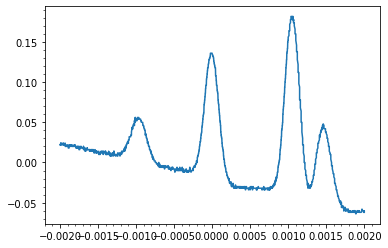

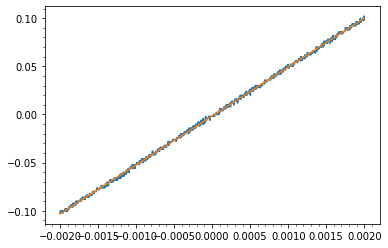

In [85]:
data =  pd.read_csv("New Data\Spectrum2 blocked/A0034CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data\Spectrum2 blocked/A0034CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

#plt.plot(rampx,rampy)

j = 0
for i in x:
    if i == -0.002:
        t1 = j
    if i == 0.002:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

#y = y + 0.333333333*rampy + 0.01

RampGuess = [5, -2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]

print(RampSlope)

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0011721875806530925
[-1.84678809e+01 -1.38267820e-02]


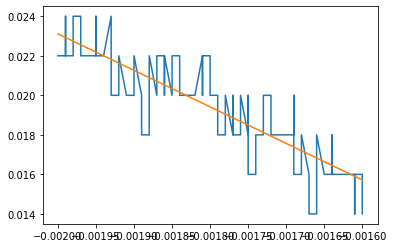

In [86]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.002:
        t1 = j
    if i == -0.0016:
        t2 = j
    j += 1
    
x_flat = x[t1:t2]
y_flat = y[t1:t2]

Back_guess = [-18,-.014]

def linfunc(x_pts, a, b):
    return a * x_pts + b

Back_popt, Back_pcov = optimize.curve_fit(linfunc, x_flat, y_flat, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_flat - linfunc(x_flat, *Back_popt))**2 ) / (np.size(x_flat) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_flat,y_flat)
plt.plot(x_flat, linfunc(x_flat, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

Reduced Chi Squared = 22.22717639600806


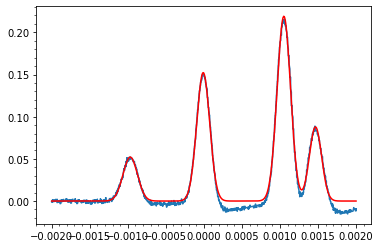

Reduced Chi Squared = 22.22717640066764


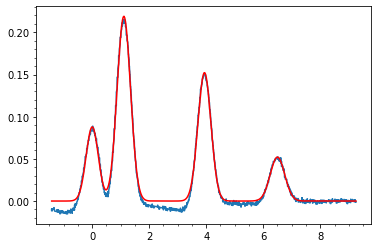

87Rb F=2 Seperation: 1.6722751863756858e-06 +/- 0.002261911626055564
87Rb F=2 FWHM: -0.3027182576385008 +/- 0.003219327394738336
85Rb F=3 Seperation: 1.1096108038622583 +/- 0.0009508356183713817
85Rb F=3 FWHM: 0.33289213361451014 +/- 0.0013544679533790513
85Rb F=2 Seperation: 3.9383565524589583 +/- 0.0013462416091450514
85Rb F=2 FWHM: 0.32305989949738734 +/- 0.0019038731321657824
87Rb F=1 Seperation: 6.499213515684774 +/- 0.004142303631639172
87Rb F=1 FWHM: 0.35800659767354304 +/- 0.005854882423222726


In [88]:
# Fit curve, apply Calibration, fit again
#y = y - (linfunc(x, *Back_popt))

guess = [-0.001, 0.05000, 0.00020, 0.0, 0.15000, 0.00020, 0.001, 0.21000, 0.00020, 0.0015, 0.05000, 0.00020]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=150000)
fit = func(x, *popt)
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()


# Calibration
Calx = Cali(x, popt[9], RampSlope, FPTriSlope, FP_Period)

Cguess = [0.0, 0.05000, 0.606, 1.136, 0.15, 0.541, 4.044, 0.20, 0.524, 6.518, 0.05, 0.559]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, Calx, y, p0=Cguess, maxfev=150000)
fit = func(Calx, *popt)
RCS = RdChiSqrd(y, func(Calx, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

print("87Rb F=2 Seperation: " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0,0])) )
print("87Rb F=2 FWHM: " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2,2])) )
print("85Rb F=3 Seperation: " + str(popt[3]) + " +/- " + str(np.sqrt(pcov[3,3])) )
print("85Rb F=3 FWHM: " + str(popt[5]) + " +/- " + str(np.sqrt(pcov[5,5])) )
print("85Rb F=2 Seperation: " + str(popt[6]) + " +/- " + str(np.sqrt(pcov[6,6])) )
print("85Rb F=2 FWHM: " + str(popt[8]) + " +/- " + str(np.sqrt(pcov[8,8])) )
print("87Rb F=1 Seperation: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
print("87Rb F=1 FWHM: " + str(popt[11]) + " +/- " + str(np.sqrt(pcov[11,11])) )